# eBOSS v6 Analyses

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import os
import fitsio as ft
import healpy as hp
import numpy as np
from   glob import glob
import pandas as pd
import seaborn as sns

# PATHS to my storage
# mehdi  @ cori
# rezaie @ OU iMac
HOME    = os.getenv('HOME')
USER    = os.getenv('USER')
sys.path.append(HOME + '/github/SYSNet/src')
from prepare import CAT, combinemaps, hd5_2_fits
from dataviz import hyper_params_data
import utils as ut
import nnbar
#from utils import split2Kfolds, split2KfoldsSpatially
dirs    = dict(rezaie='/Volumes/TimeMachine/data/', mehdi='/global/cscratch1/sd/mehdi/')
scratch = dirs[USER]
print('home is {}'.format(HOME))

camb is not installed!
home is /Users/rezaie
home is /Users/rezaie


In [2]:
mpl.rcParams.update(mpl.rcParamsDefault)
params = {
'axes.spines.right':True,
'axes.spines.top':True,
'axes.labelsize': 15,
#'text.fontsize': 8,
'legend.fontsize': 8,
'xtick.labelsize': 12,
'ytick.labelsize': 12,
'text.usetex': False,
'figure.figsize': [4, 3],
'font.family':'serif',
'font.size':12
}    
plt.rcParams.update(params)

## aug 2: with new imaging maps

check for extreme weights

In [7]:
maps = glob('/Volumes/TimeMachine/data/eboss/v6/results_*/regression/nn_*/nn-weights.hp512.fits')
maps

['/Volumes/TimeMachine/data/eboss/v6/results_all/regression/nn_ab/nn-weights.hp512.fits',
 '/Volumes/TimeMachine/data/eboss/v6/results_all/regression/nn_p/nn-weights.hp512.fits',
 '/Volumes/TimeMachine/data/eboss/v6/results_ngc/regression/nn_ab/nn-weights.hp512.fits',
 '/Volumes/TimeMachine/data/eboss/v6/results_ngc/regression/nn_p/nn-weights.hp512.fits',
 '/Volumes/TimeMachine/data/eboss/v6/results_sgc/regression/nn_ab/nn-weights.hp512.fits',
 '/Volumes/TimeMachine/data/eboss/v6/results_sgc/regression/nn_p/nn-weights.hp512.fits']

In [10]:
for m in maps:
    md = hp.read_map(m, verbose=False)
    print(md[md!=0.0].max())

1.2549029904089268
2.790826806603092
1.13463830562509
1.180743273148738
1.2104481997630612
1.2407585451169287


In [5]:
cls =  glob('/Volumes/TimeMachine/data/eboss/v6/results_sgc/clustering/cl_uni.npy')\
       + glob('/Volumes/TimeMachine/data/eboss/v6/results_sgc/clustering/cl_nn_*.npy')\
       + glob('/Volumes/TimeMachine/data/eboss/v6/results_sgc/clustering/cl_uni_wsys.npy')
print(cls)

['/Volumes/TimeMachine/data/eboss/v6/results_sgc/clustering/cl_uni.npy', '/Volumes/TimeMachine/data/eboss/v6/results_sgc/clustering/cl_nn_ab.npy', '/Volumes/TimeMachine/data/eboss/v6/results_sgc/clustering/cl_nn_p.npy', '/Volumes/TimeMachine/data/eboss/v6/results_sgc/clustering/cl_uni_wsys.npy']


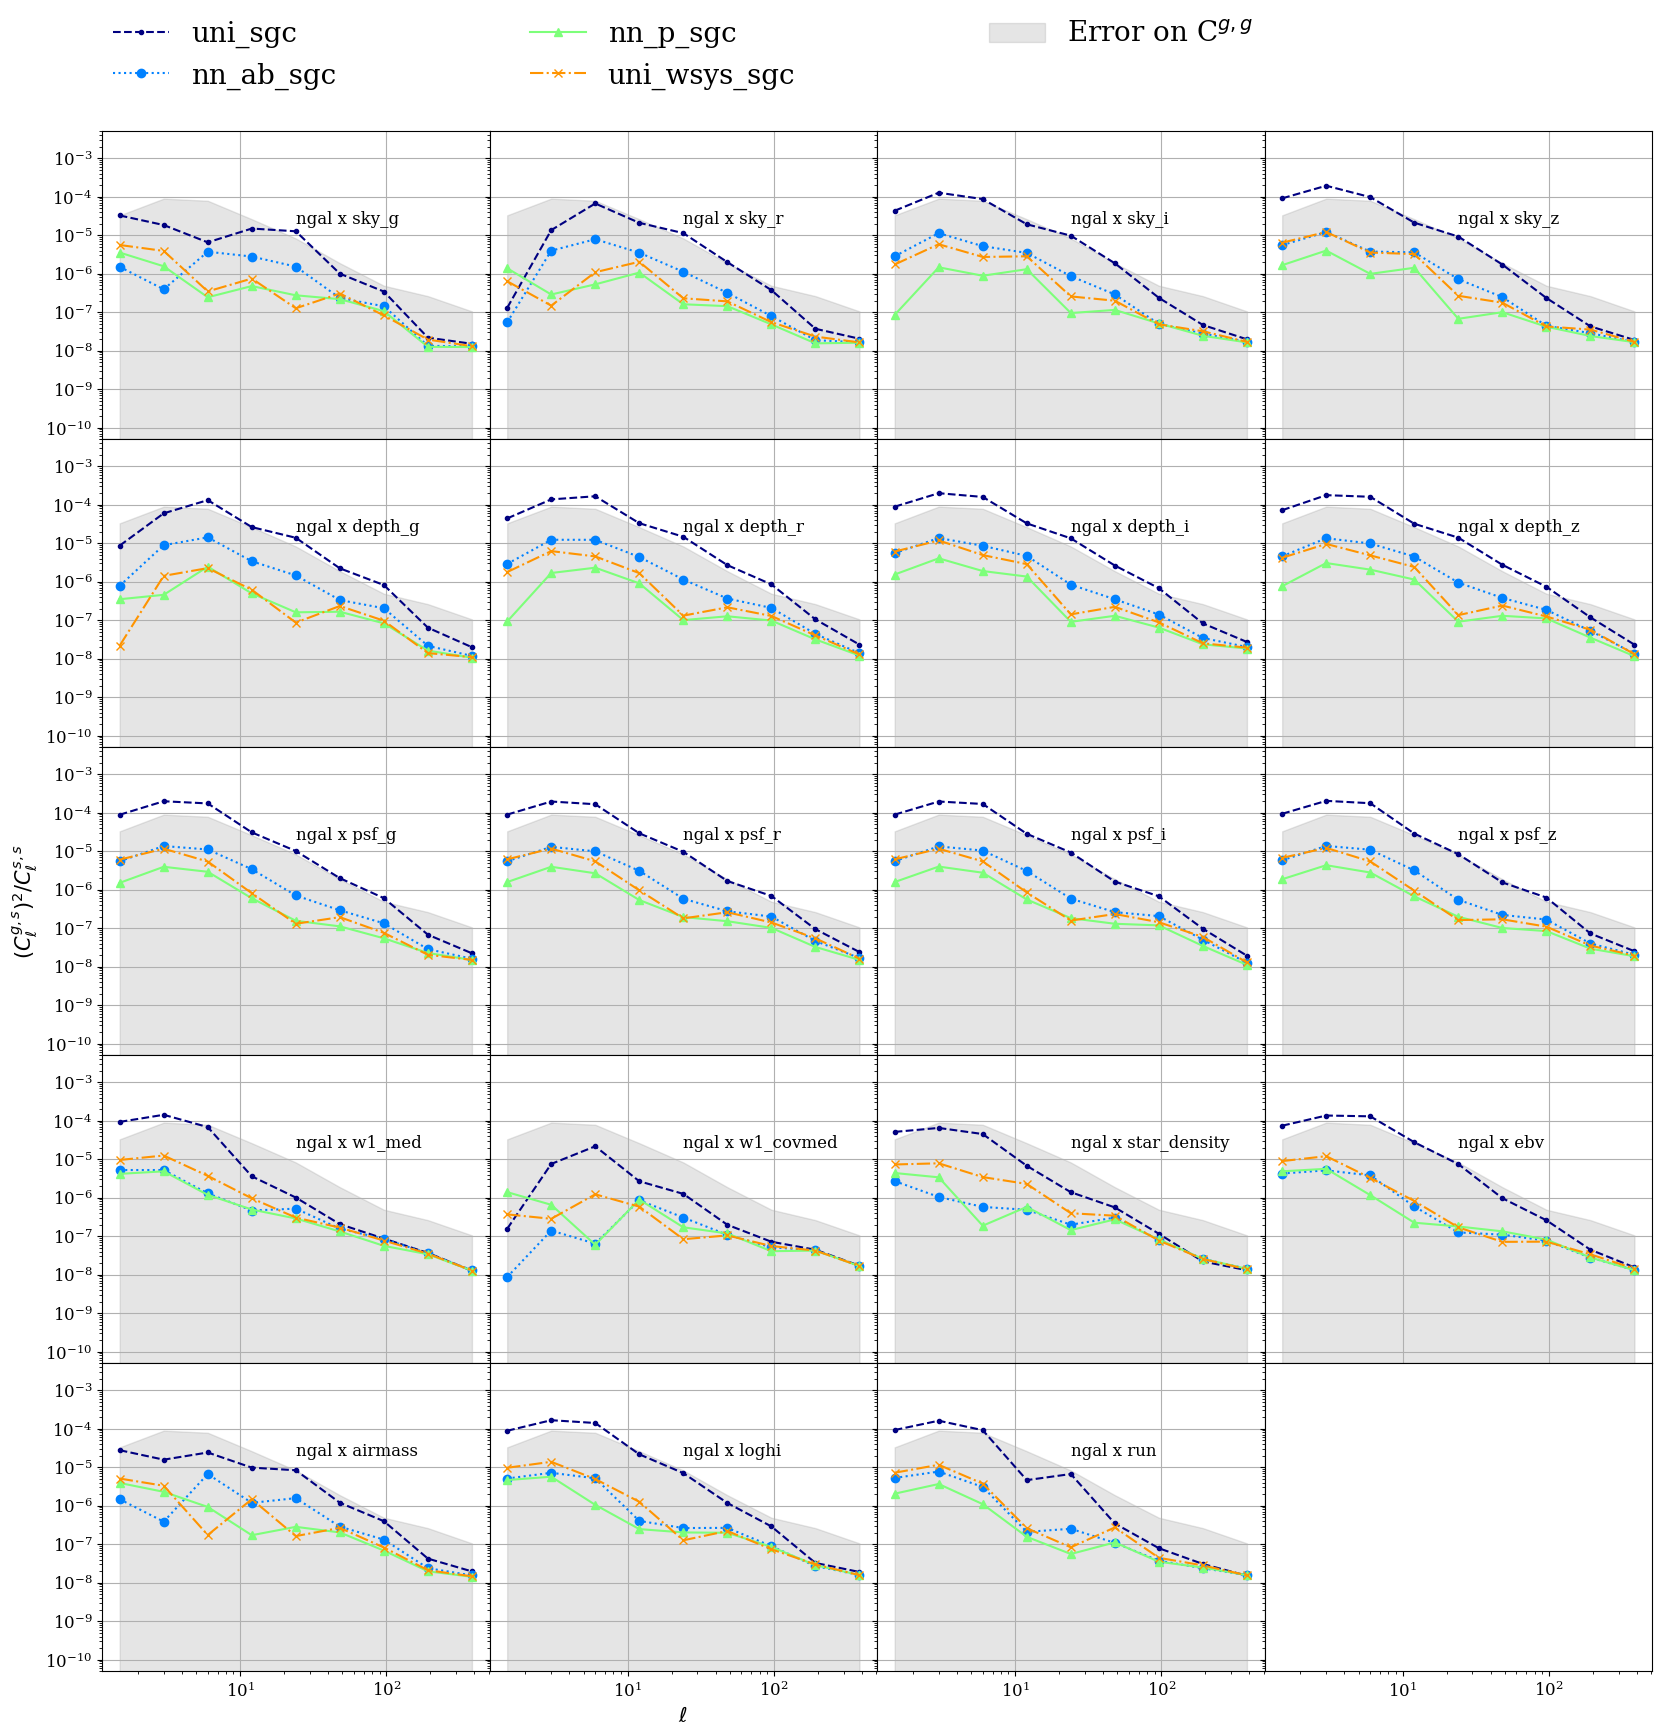

In [6]:
fig, ax = plt.subplots(ncols=4, nrows=5, figsize=(20, 20), sharey=True, sharex=True)
plt.subplots_adjust(hspace=0., wspace=0)
ax = ax.flatten()

clsys = np.load('/Volumes/TimeMachine/data/eboss/v6/results_sgc/clustering/cl_sys.npy').item()
#lt = ['lin', 'NN+Ablation', 'NN', 'quad', 'No Correction']
#cl = ['r', 'b', 'k', 'g', 'purple']
ls = ['--', ':', '-', '-.', '-']
mk = ['.', 'o', '^', 'x']
n  = len(cls)
clr  = plt.cm.jet
for j,cell_i in enumerate(cls):
    d = np.load(cell_i).item()
    lt = '_'.join((cell_i.split('/')[-1].split('.')[0][3:], cell_i.split('/')[6].split('_')[-1]))
    for i in range(d['cross'].shape[0]):
        l = np.arange(d['cross'][i, :].size)
        cl= d['cross'][i, :]**2 / clsys['cross'][i, :]
        lb, clb = ut.binit(l, cl)
        #print(lb, clb)
        #a[i].plot(l, cl, color=color, label=label, linestyle=ls)
        ax[i].plot(lb, clb, color=clr(j/n), label=lt, marker=mk[j], linestyle=ls[j])
        if j ==n-1:
            ax[0].legend(**dict(ncol=3,frameon=False,
                 bbox_to_anchor=(0, 1.1, 3, 0.4), loc="lower left",
                mode="expand", borderaxespad=0, fontsize=20))
            ax[i].set_xscale('log')
            #ax[0].set_xlim(1, 3)
            ax[i].set_ylim(5.e-11, 5.e-3)
            ax[i].set_yscale('log')
            ax[i].text(0.5, 0.7, 'ngal x %s'%d['clabels'][i], transform=ax[i].transAxes)
            ax[i].grid()
            if i==8:ax[i].set_ylabel(r'$(C^{g,s}_{\ell})^{2}/C^{s,s}_{\ell}$')
            if i==17:ax[i].set_xlabel(r'$\ell$')
    if j==0:
        lb, clbe = ut.binit_jac(d['clerr']['cljks'])
        for i in range(d['cross'].shape[0]):
            ax[i].fill_between(lb, 1.e-13, clbe, color='grey', label=r'Error on C$^{g,g}$', alpha=0.2)
plt.show()                

In [2]:
nnbars = glob('/Volumes/TimeMachine/data/eboss/v6/results_ngc/clustering/nnbar_uni.npy')\
       + glob('/Volumes/TimeMachine/data/eboss/v6/results_ngc/clustering/nnbar_nn_*.npy')\
       + glob('/Volumes/TimeMachine/data/eboss/v6/results_ngc/clustering/nnbar_uni_wsys.npy')
print(nnbars)

['/Volumes/TimeMachine/data/eboss/v6/results_ngc/clustering/nnbar_uni.npy', '/Volumes/TimeMachine/data/eboss/v6/results_ngc/clustering/nnbar_nn_ab.npy', '/Volumes/TimeMachine/data/eboss/v6/results_ngc/clustering/nnbar_nn_p.npy', '/Volumes/TimeMachine/data/eboss/v6/results_ngc/clustering/nnbar_uni_wsys.npy']


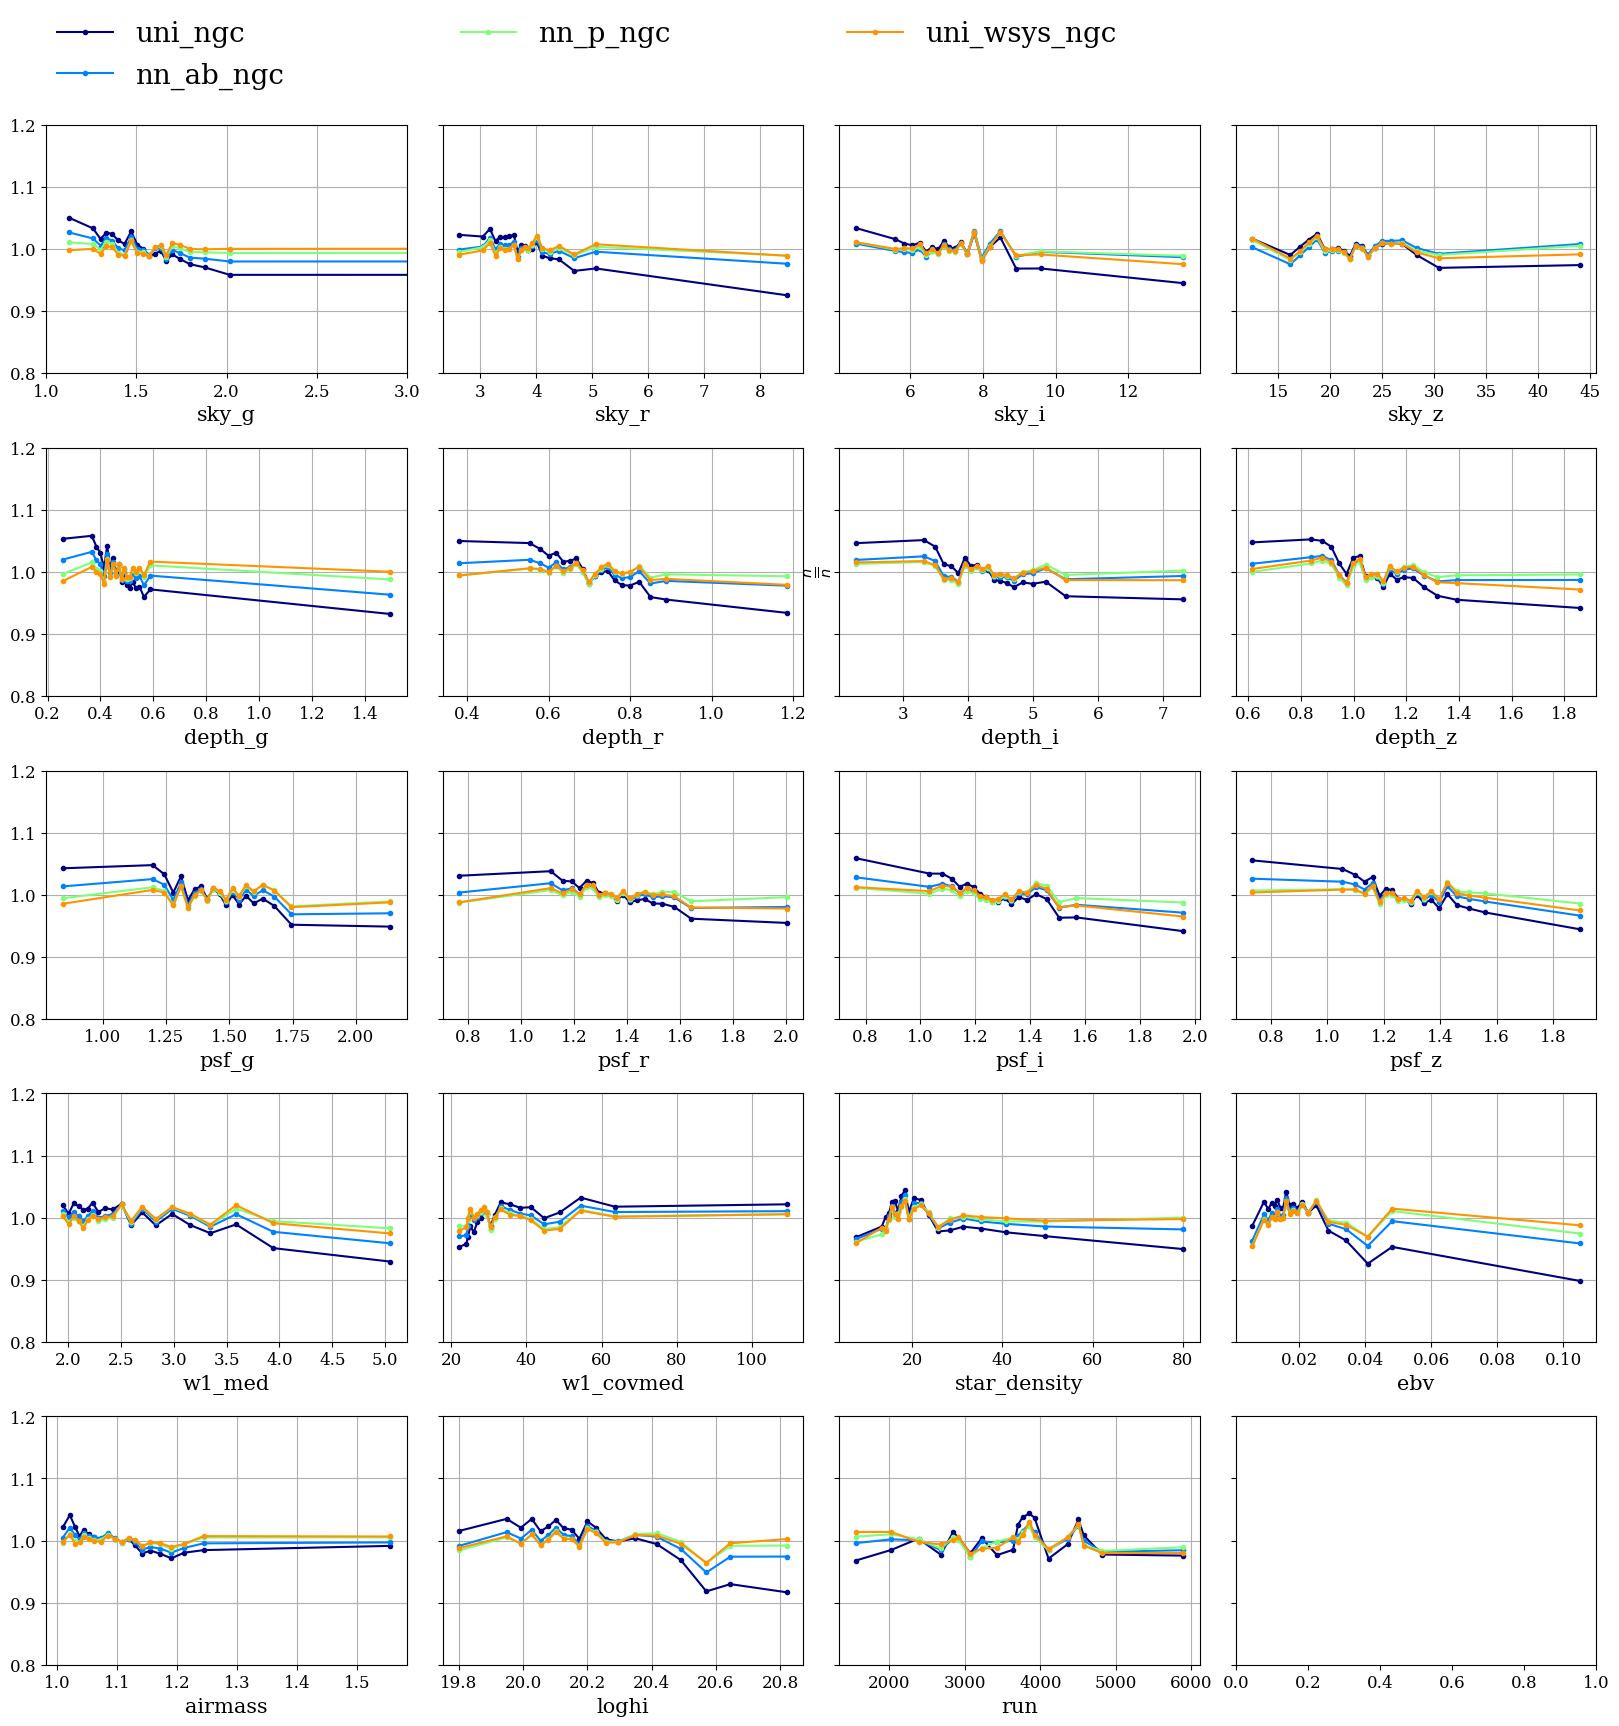

In [4]:
mpl.rcParams.update(mpl.rcParamsDefault)
params = {
'axes.spines.right':True,
'axes.spines.top':True,
'axes.labelsize': 15,
#'text.fontsize': 8,
'legend.fontsize': 8,
'xtick.labelsize': 12,
'ytick.labelsize': 12,
'text.usetex': False,
'figure.figsize': [4, 3],
'font.family':'serif',
'font.size':12
}    
plt.rcParams.update(params) 

fig, ax = plt.subplots(ncols=4, nrows=5, figsize=(20, 20), sharey=True)
plt.subplots_adjust(hspace=0.3, wspace=0.1)
ax = ax.flatten()

#lt = ['lin', 'NN+Ablation', 'NN', 'quad', 'No Correction']
#cl = ['r', 'b', 'k', 'g', 'purple']
ls = ['--', ':', '-', '-.', '-']
n  = len(nnbars)
cl  = plt.cm.jet
for j,nnbar_i in enumerate(nnbars):
    nnbar = np.load(nnbar_i).item()
    lt = '_'.join((nnbar_i.split('/')[-1].split('.')[0][6:], nnbar_i.split('/')[6].split('_')[-1]))
    for i in range(len(nnbar['nnbar'])):
        mynnb = nnbar['nnbar'][i]
        x = 0.5*(mynnb['bin_edges'][1:]+mynnb['bin_edges'][:-1])
        y = mynnb['nnbar']
        ye = mynnb['nnbar_err']
        ax[i].plot(x, y, marker='.', color=cl(j/n), label=lt)
        if j ==n-1:
            ax[0].legend(**dict(ncol=3,frameon=False,
                 bbox_to_anchor=(0, 1.1, 3, 0.4), loc="lower left",
                mode="expand", borderaxespad=0, fontsize=20))
            ax[0].set_xlim(1, 3)
            ax[i].set_ylim(0.8, 1.2)
            ax[i].set_xlabel(nnbar['xlabels'][i])
            ax[i].grid()
            if i==6:ax[i].set_ylabel(r'$\frac{n}{\overline{n}}$')
plt.show()                

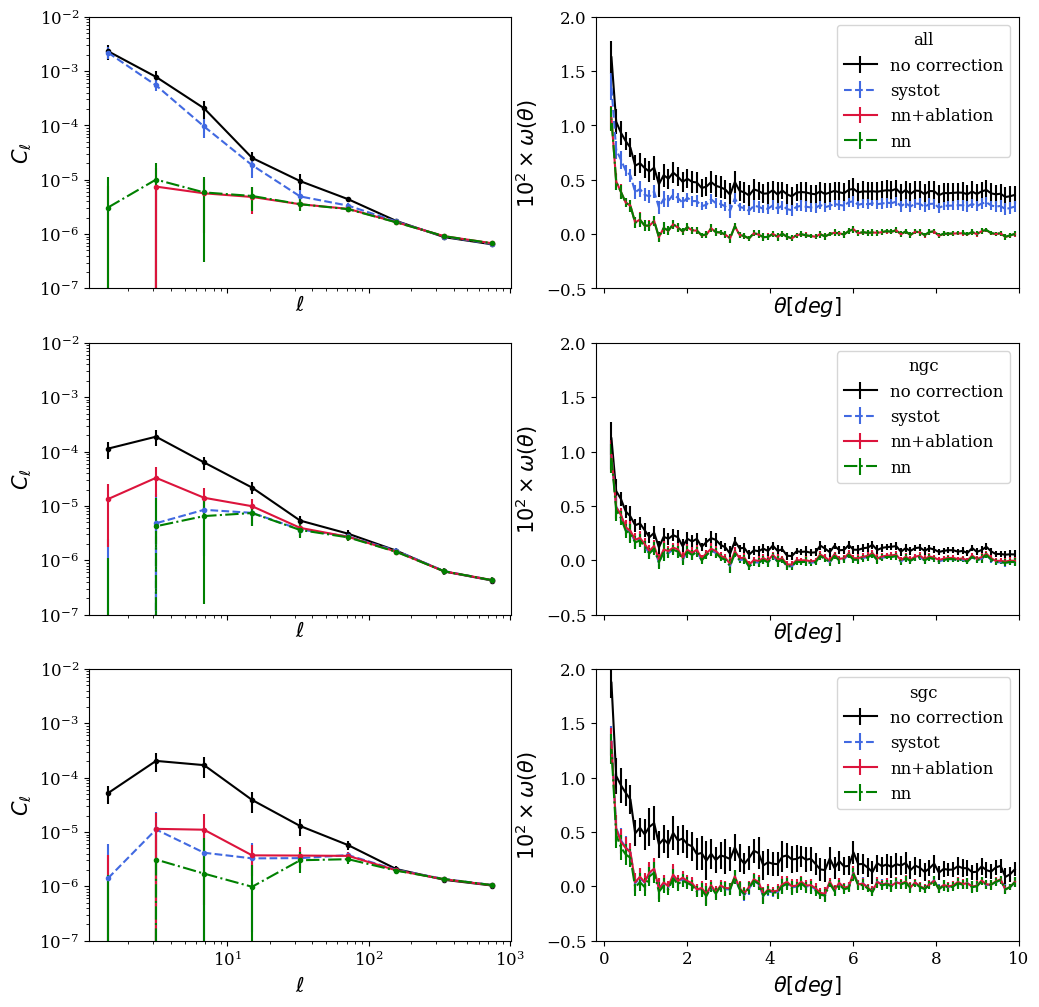

In [10]:
def plot_clxi(filen, filen2, ax, ttl):    
    mpl.rcParams.update(mpl.rcParamsDefault)
    params = {
    'axes.spines.right':True,
    'axes.spines.top':True,
    'axes.labelsize': 15,
    #'text.fontsize': 8,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex': False,
    'figure.figsize': [4, 3],
    'font.family':'serif',
    'font.size':12
    }    
    plt.rcParams.update(params) 

    lb = ['uni', 'uni_wsys', 'nn_ab', 'nn_p']
    lt = ['no correction', 'systot', 'nn+ablation', 'nn']
    c  = ['k', 'royalblue', 'crimson', 'g', '', 'purple']
    ls = ['-', '--', '-', '-.', '', '-']

#     fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
#     plt.subplots_adjust(wspace=0.4)

    kw = dict(bins=np.logspace(np.log10(0.9), np.log10(1030), 10))
    for i,lbi in enumerate(lb):
        cl = np.load(filen(lbi)).item()
        elb, clbe = ut.binit_jac(cl['clerr']['cljks'], **kw)
        elb, clb  = ut.binit(np.arange(cl['auto'].size), cl['auto']-4.295060549836234e-6, **kw)
        #print(clb)
        ax[0].errorbar(elb, clb, yerr=clbe, marker='.', linestyle=ls[i], color=c[i], label=lt[i])

    ax[0].loglog()
    ax[0].set_ylim(1.e-7, 1.e-2)
    ax[0].set_xlabel(r'$\ell$')
    ax[0].set_ylabel(r'$C_{\ell}$')

    fc = 1.e2
    for i, xii in enumerate(lb):
        d = np.load(filen2(xii)).item()['auto']
        t  = 0.5*np.degrees(d['t'][1:]+d['t'][:-1])
        xi = fc*(d['w']-d['dmean']*d['dmean'])

        xierr=d['werr']
        ax[1].errorbar(t, xi, yerr=fc*xierr, linestyle=ls[i], color=c[i], label=lt[i])
        #ax[0].legend(bbox_to_anchor=(0, 1.1, 2, 0.4), loc="lower left",
        #            mode="expand", borderaxespad=0, ncol=3, frameon=False)    
        ax[1].set_xlabel(r'$\theta [deg]$')
        ax[1].set_ylabel(r'$10^{2}\times \omega(\theta)$')
        ax[1].set_xlim(-0.2, 10)
        ax[1].set_ylim(-0.5, 2.0)
        ax[1].grid()
        ax[1].legend(title=ttl)        
    #plt.show()
    

fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(12, 12), sharex='col')
ax = ax.flatten()
# plt.subplots_adjust(hspace=0.0)

for i,cap in enumerate(['all', 'ngc', 'sgc']):
    filen = lambda l:'/Volumes/TimeMachine/data/eboss/v6/results_'+cap+'/clustering/cl_'+l+'.npy'
    filen2 = lambda l:'/Volumes/TimeMachine/data/eboss/v6/results_'+cap+'/clustering/xi_'+l+'.npy'
    plot_clxi(filen, filen2, [ax[2*i], ax[2*i+1]], cap)
plt.show()    

## Aug 1: make new table file

In [29]:
# check if there is any NaN
d = ft.read('/Volumes/TimeMachine/data/eboss/v6/ngal_features_all.fits', lower=True)
for n in d.dtype.names:
    print('nans', np.isnan(d[n]).sum(), end=' ')
    print('stds', np.std(d[n], axis=0))

nans 0 stds 1.3312071177033697
nans 0 stds 417753.6023250429
nans 0 stds [1.40526413e+00 1.24345386e+00 2.31460641e+00 7.94370185e+00
 1.19607491e-01 1.75159806e-01 1.04947017e+00 2.62109772e-01
 2.20412611e-01 2.15221350e-01 2.13114467e-01 1.97432038e-01
 8.66234798e-01 1.35547310e+01 1.91764408e+01 2.67488185e-02
 1.71216873e-01 2.75545342e-01 2.09055012e+03]
nans 0 stds 0.27293532923452124


In [30]:
d['features'].shape

(392502, 19)

In [25]:
# combine them
COLS = ['sky_g', 'sky_r', 'sky_i', 'sky_z', 
        'depth_g', 'depth_r', 'depth_i','depth_z',
        'psf_g','psf_r', 'psf_i', 'psf_z',
        'w1_med', 'w1_covmed',
        'star_density', 'ebv', 'airmass', 'loghi', 'run']

for cap in ['all', 'sgc', 'ngc']:    
    print('working on %s'%cap)
    pdm = combinemaps(scratch+'eboss/v6/eBOSS_QSO_clustering_'+cap+'_v6.dat.hp.512.fits',
                      scratch+'eboss/v6/eBOSS_QSO_clustering_'+cap+'_v6.ran.hp.512.fits',
                      scratch +'/eboss/sysmaps/SDSS_WISE_HI_imageprop_nside512.fits')
    pdm.maketable(cols=COLS)
    pdm.to_hdf(scratch+'eboss/v6/qso_hpsyst_'+cap+'.hf', 'qso_hpsyst', mode='w', format='fixed')
    # read hdf, write label, features to fits
    fitname = '/Volumes/TimeMachine/data/eboss/v6/ngal_features_'+cap+'.fits'
    metaname = '/Volumes/TimeMachine/data/eboss/v6/qso_hpsyst_'+cap+'.hf'
    hpmask   = '/Volumes/TimeMachine/data/eboss/v6/mask.'+cap+'.hp.512.fits'
    hpfrac   = '/Volumes/TimeMachine/data/eboss/v6/fracgood.'+cap+'.hp.512.fits'
    hd5_2_fits(metaname, fitname, hpmask, hpfrac, COLS)
    # randomly split the label features into 5 partitions
    ut.read_split_write('/Volumes/TimeMachine/data/eboss/v6/ngal_features_'+cap+'.fits', 
                   '/Volumes/TimeMachine/data/eboss/v6/qso.'+cap+'.hp.512.r',
                   5)

working on all
attributes : ('nran', 'sky_g', 'sky_r', 'sky_i', 'sky_z', 'airmass', 'ebv', 'depth_g', 'depth_r', 'depth_i', 'depth_z', 'psf_g', 'psf_r', 'psf_i', 'psf_z', 'w1_med', 'w1_covmed', 'w1_moon', 'star_density', 'loghi', 'run')
total mask ran > 0 : 392584
total mask after nan maps : 392502
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3145728 entries, 0 to 3145727
Data columns (total 22 columns):
ngal            float64
nran            float64
mask            bool
sky_g           float64
sky_r           float64
sky_i           float64
sky_z           float64
depth_g         float64
depth_r         float64
depth_i         float64
depth_z         float64
psf_g           float64
psf_r           float64
psf_i           float64
psf_z           float64
w1_med          float64
w1_covmed       float64
star_density    float64
ebv             float64
airmass         float64
loghi           float64
run             float64
dtypes: bool(1), float64(21)
memory usage: 507.0 MB
Info :  No

* Add mean Run and logHI

In [14]:
maps = ft.read('/Volumes/TimeMachine/data/eboss/sysmaps/SDSS_WISE_imageprop_nside512.fits', lower=True)
maps.dtype.names

('nran',
 'sky_g',
 'sky_r',
 'sky_i',
 'sky_z',
 'airmass',
 'ebv',
 'depth_g',
 'depth_r',
 'depth_i',
 'depth_z',
 'psf_g',
 'psf_r',
 'psf_i',
 'psf_z',
 'w1_med',
 'w1_covmed',
 'w1_moon',
 'star_density')

In [15]:
logHI   = np.log10(ut.fixHI(nside_out=512))
meanrun = hp.read_map('/Volumes/TimeMachine/data/eboss/sysmaps/sdss_run_mean_512.fits', verbose=False)

/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


In [21]:
newmaps = ut.rfn.append_fields(maps, ['logHI', 'run'], data=[logHI, meanrun], dtypes=['>f8', '>f8'], usemask=False)

In [23]:
newmaps.dtype

dtype([('nran', '>f8'), ('sky_g', '>f8'), ('sky_r', '>f8'), ('sky_i', '>f8'), ('sky_z', '>f8'), ('airmass', '>f8'), ('ebv', '>f8'), ('depth_g', '>f8'), ('depth_r', '>f8'), ('depth_i', '>f8'), ('depth_z', '>f8'), ('psf_g', '>f8'), ('psf_r', '>f8'), ('psf_i', '>f8'), ('psf_z', '>f8'), ('w1_med', '>f8'), ('w1_covmed', '>f8'), ('w1_moon', '>f8'), ('star_density', '>f8'), ('logHI', '>f8'), ('run', '>f8')])

In [22]:
ft.write('/Volumes/TimeMachine/data/eboss/sysmaps/SDSS_WISE_HI_imageprop_nside512.fits', newmaps)

### check if there is any trend agains mean run

In [2]:
sdssran = ft.read('/Volumes/TimeMachine/data/eboss/sysmaps/eBOSSrandoms.ran.fits', lower=True)
sdssran.dtype

dtype([('ra', '>f8'), ('dec', '>f8'), ('ipoly', '>i2'), ('isect', '>i2'), ('skyflux', '>f4', (5,)), ('airmass', '>f4'), ('eb_minus_v', '>f4'), ('image_depth', '>f4', (5,)), ('psf_fwhm', '>f4', (5,)), ('run', '>i4'), ('rerun', 'S3'), ('camcol', '>i4'), ('field', '>i4')])

In [9]:
nside = 512
hprun = ut.projectradec2hp(nside, sdssran['ra'], sdssran['dec'], sdssran['run'], statistic='mean')

/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/projaxes.py:1053: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/projaxes.py:1054: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


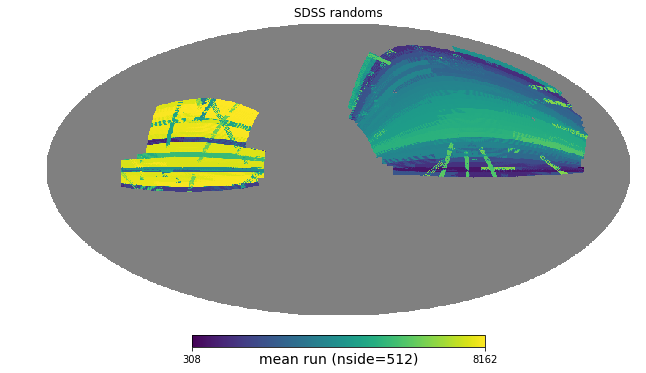

In [10]:
hp.mollview(hprun, unit='mean run (nside=512)', rot=-89, title='SDSS randoms')

In [11]:
hp.write_map('/Volumes/TimeMachine/data/eboss/sysmaps/sdss_run_mean_512.fits', hprun, fits_IDL=False)

In [2]:
hprun = hp.read_map('/Volumes/TimeMachine/data/eboss/sysmaps/sdss_run_mean_512.fits')

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


In [3]:
ghp = lambda cap: '/Volumes/TimeMachine/data/eboss/v6/eBOSS_QSO_clustering_'+cap+'_v6.dat.hp.512.fits'
rhp = lambda cap: '/Volumes/TimeMachine/data/eboss/v6/eBOSS_QSO_clustering_'+cap+'_v6.ran.hp.512.fits'
msk = lambda cap: '/Volumes/TimeMachine/data/eboss/v6/mask.'+cap+'.hp.512.fits'

min sys : 1302.00  max sys : 6752.00
num of pts : 237220, num of bins : 20
min sys : 109.00  max sys : 8162.00
num of pts : 155282, num of bins : 20
min sys : 1302.00  max sys : 6752.00
num of pts : 237220, num of bins : 20
min sys : 109.00  max sys : 8162.00
num of pts : 155282, num of bins : 20


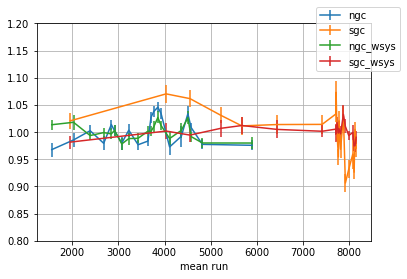

In [13]:
fig, ax = plt.subplots()
kw = dict(verbose=False)
CAPS = ['ngc', 'sgc', 'ngc_wsys', 'sgc_wsys']

for lb in CAPS:
    galmap = hp.read_map(ghp(lb), **kw)
    if 'wsys' in lb:
        lb2 = lb[:3]
    else:
        lb2 = lb
    ranmap = hp.read_map(rhp(lb2), **kw)
    mask   = hp.read_map(msk(lb2), **kw).astype('bool')
    nnb = nnbar.NNBAR(galmap, ranmap, mask, hprun, binning='equi-area')
    nnb.run()
    res = nnb.output
    x   = 0.5 * (res['bin_edges'][1:]+res['bin_edges'][:-1])
    y   = res['nnbar']
    ye  = res['nnbar_err']
    ax.errorbar(x, y, yerr=ye, label=lb)
ax.set_ylim(0.8, 1.2)
ax.set_xlabel('mean run')
ax.legend(bbox_to_anchor=(1.1, 1.1))
ax.grid()

## Jul 31: check if there is a residual against the lnHI

In [2]:
HI = ut.fixHI(nside_out=512)
logHI = np.log10(HI)

/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


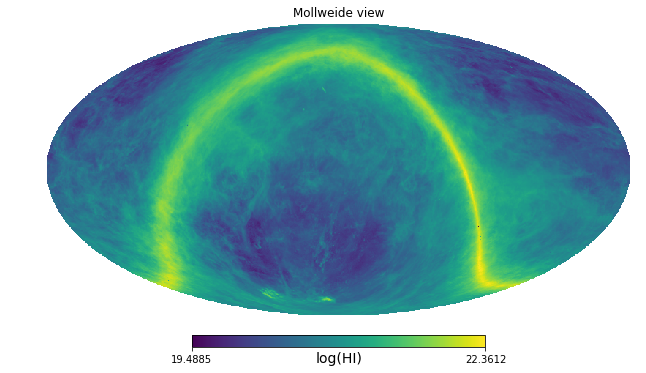

In [3]:
hp.mollview(logHI, unit='log(HI)')

In [5]:
ghp = lambda cap: '/Volumes/TimeMachine/data/eboss/v6/eBOSS_QSO_clustering_'+cap+'_v6.dat.hp.512.fits'
rhp = lambda cap: '/Volumes/TimeMachine/data/eboss/v6/eBOSS_QSO_clustering_'+cap+'_v6.ran.hp.512.fits'
msk = lambda cap: '/Volumes/TimeMachine/data/eboss/v6/mask.'+cap+'.hp.512.fits'

In [16]:
ls /Volumes/TimeMachine/data/eboss/v6/eBOSS_QSO_clustering_*hp*

/Volumes/TimeMachine/data/eboss/v6/eBOSS_QSO_clustering_all_v6.dat.hp.512.fits
/Volumes/TimeMachine/data/eboss/v6/eBOSS_QSO_clustering_all_v6.ran.hp.512.fits
/Volumes/TimeMachine/data/eboss/v6/eBOSS_QSO_clustering_all_wsys_v6.dat.hp.512.fits
/Volumes/TimeMachine/data/eboss/v6/eBOSS_QSO_clustering_ngc_v6.dat.hp.512.fits
/Volumes/TimeMachine/data/eboss/v6/eBOSS_QSO_clustering_ngc_v6.ran.hp.512.fits
/Volumes/TimeMachine/data/eboss/v6/eBOSS_QSO_clustering_ngc_wsys_v6.dat.hp.512.fits
/Volumes/TimeMachine/data/eboss/v6/eBOSS_QSO_clustering_sgc_v6.dat.hp.512.fits
/Volumes/TimeMachine/data/eboss/v6/eBOSS_QSO_clustering_sgc_v6.ran.hp.512.fits
/Volumes/TimeMachine/data/eboss/v6/eBOSS_QSO_clustering_sgc_wsys_v6.dat.hp.512.fits


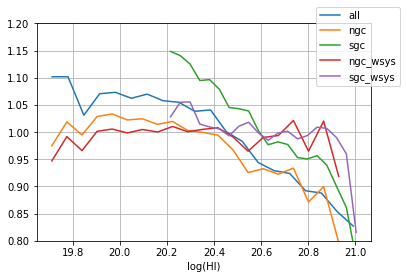

In [18]:
fig, ax = plt.subplots()
kw = dict(verbose=False)
CAPS = ['all', 'ngc', 'sgc', 'ngc_wsys', 'sgc_wsys']

for lb in CAPS:
    galmap = hp.read_map(ghp(lb), **kw)
    if 'wsys' in lb:
        lb2 = lb[:3]
    else:
        lb2 = lb
    ranmap = hp.read_map(rhp(lb2), **kw)
    mask   = hp.read_map(msk(lb2), **kw).astype('bool')
    nnb = nnbar.NNBAR(galmap, ranmap, mask, logHI, binning='simple')
    nnb.run()
    res = nnb.output
    x   = 0.5 * (res['bin_edges'][1:]+res['bin_edges'][:-1])
    y   = res['nnbar']
    ax.plot(x, y, label=lb)
ax.set_ylim(0.8, 1.2)
ax.set_xlabel('log(HI)')
ax.legend(bbox_to_anchor=(1.1, 1.1))
ax.grid()

## project catalogs to healpix maps, prepare for regression and clustering

Jul 24:  w1_moon is zero for all NGC pixels, we removed it!

### SGC+NGC

len of gal cats 2
num of gal obj 342394
projecting into a healpix map with nside of 512


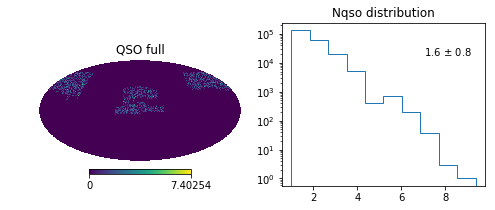

len of gal cats 2
num of gal obj 342394
projecting into a healpix map with nside of 512


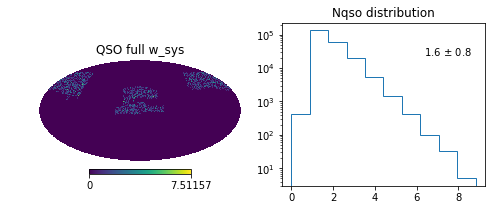

len of gal cats 2
num of gal obj 9153197
projecting into a healpix map with nside of 512


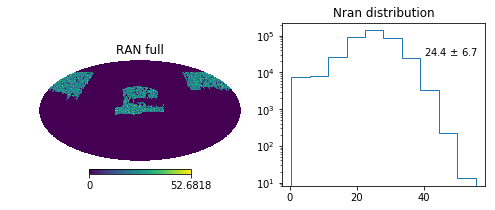

attributes : ('nran', 'sky_g', 'sky_r', 'sky_i', 'sky_z', 'airmass', 'ebv', 'depth_g', 'depth_r', 'depth_i', 'depth_z', 'psf_g', 'psf_r', 'psf_i', 'psf_z', 'w1_med', 'w1_covmed', 'w1_moon', 'star_density')
total mask ran > 0 : 392584
total mask after nan maps : 392502
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3145728 entries, 0 to 3145727
Data columns (total 20 columns):
ngal            float64
nran            float64
mask            bool
sky_g           float64
sky_r           float64
sky_i           float64
sky_z           float64
depth_g         float64
depth_r         float64
depth_i         float64
depth_z         float64
psf_g           float64
psf_r           float64
psf_i           float64
psf_z           float64
w1_med          float64
w1_covmed       float64
star_density    float64
ebv             float64
airmass         float64
dtypes: bool(1), float64(19)
memory usage: 459.0 MB
Info :  None



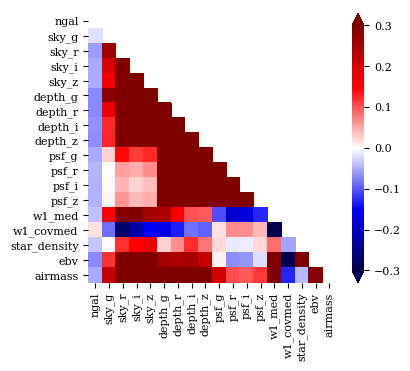

/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/projaxes.py:1053: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/projaxes.py:1054: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


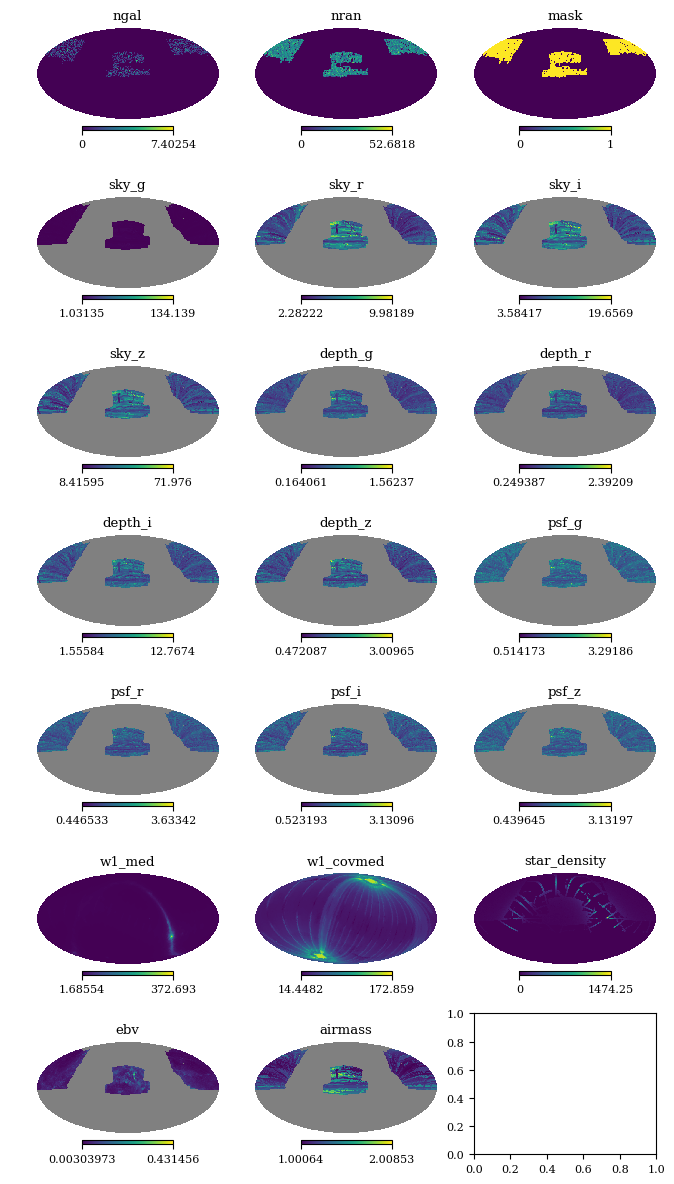

wrote /Volumes/TimeMachine/data/eboss/v6/ngal_features_all.fits
wrote /Volumes/TimeMachine/data/eboss/v6/mask.all.hp.512.fits
wrote /Volumes/TimeMachine/data/eboss/v6/fracgood.all.hp.512.fits


In [2]:
# data
qsocat = CAT([scratch+'eboss/v6/eBOSS_QSO_clustering_NGC_v6.dat.fits', 
              scratch+'eboss/v6/eBOSS_QSO_clustering_SGC_v6.dat.fits'])
qsocat.project2hp()
qsocat.writehp(scratch+'eboss/v6/eBOSS_QSO_clustering_all_v6.dat.hp.512.fits')
qsocat.plot_hist(['QSO full', 'Nqso distribution'])

# data with systot
qsocat = CAT([scratch+'eboss/v6/eBOSS_QSO_clustering_NGC_v6.dat.fits', 
              scratch+'eboss/v6/eBOSS_QSO_clustering_SGC_v6.dat.fits'], 
            weights=['weight_systot', 'weight_cp', 'weight_noz'])
qsocat.project2hp()
qsocat.writehp(scratch+'eboss/v6/eBOSS_QSO_clustering_all_wsys_v6.dat.hp.512.fits')
qsocat.plot_hist(['QSO full w_sys', 'Nqso distribution'])

# random
qsocat = CAT([scratch+'eboss/v6/eBOSS_QSO_clustering_NGC_v6.ran.fits', 
              scratch+'eboss/v6/eBOSS_QSO_clustering_SGC_v6.ran.fits'],
             weights=['weight_systot', 'weight_cp', 'weight_noz'])
qsocat.project2hp()
qsocat.writehp(scratch+'eboss/v6/eBOSS_QSO_clustering_all_v6.ran.hp.512.fits')
qsocat.plot_hist(['RAN full', 'Nran distribution'])


# combine them
COLS = ['sky_g', 'sky_r', 'sky_i', 'sky_z', 
        'depth_g', 'depth_r', 'depth_i','depth_z',
        'psf_g','psf_r', 'psf_i', 'psf_z',
        'w1_med', 'w1_covmed',
        'star_density', 'ebv', 'airmass']
pdm = combinemaps(scratch+'eboss/v6/eBOSS_QSO_clustering_all_v6.dat.hp.512.fits',
                  scratch+'eboss/v6/eBOSS_QSO_clustering_all_v6.ran.hp.512.fits',
                  scratch +'/eboss/sysmaps/SDSS_WISE_imageprop_nside512.fits')
pdm.maketable(cols=COLS)
pdm.to_hdf(scratch+'eboss/v6/qso_hpsyst_all.hf', 'qso_hpsyst', mode='w', format='fixed')
pdm.plot_corrmax([-.3, .3])
pdm.plot_mollweide()

# read hdf, write label, features to fits
fitname = '/Volumes/TimeMachine/data/eboss/v6/ngal_features_all.fits'
metaname = '/Volumes/TimeMachine/data/eboss/v6/qso_hpsyst_all.hf'
hpmask   = '/Volumes/TimeMachine/data/eboss/v6/mask.all.hp.512.fits'
hpfrac   = '/Volumes/TimeMachine/data/eboss/v6/fracgood.all.hp.512.fits'
hd5_2_fits(metaname, fitname, hpmask, hpfrac, COLS)

# randomly split the label features into 5 partitions
ut.read_split_write('/Volumes/TimeMachine/data/eboss/v6/ngal_features_all.fits', 
                   '/Volumes/TimeMachine/data/eboss/v6/qso.all.hp.512.r',
                   5)

### NGC

len of gal cats 1
num of gal obj 216893
projecting into a healpix map with nside of 512
/Volumes/TimeMachine/data/eboss/v6/eBOSS_QSO_clustering_ngc_v6.dat.hp.512.fits already exists going to rewrite....


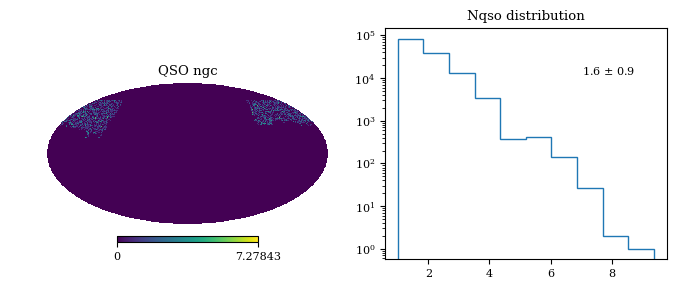

len of gal cats 1
num of gal obj 216893
projecting into a healpix map with nside of 512


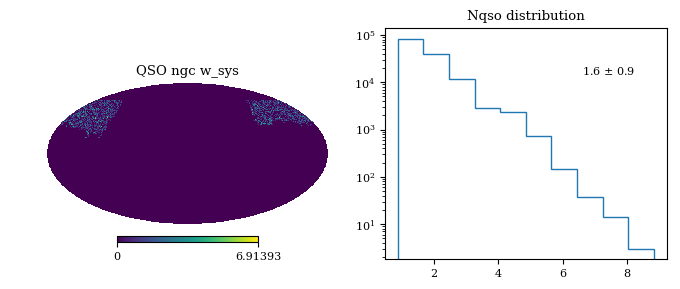

len of gal cats 1
num of gal obj 5565871
projecting into a healpix map with nside of 512
/Volumes/TimeMachine/data/eboss/v6/eBOSS_QSO_clustering_ngc_v6.ran.hp.512.fits already exists going to rewrite....


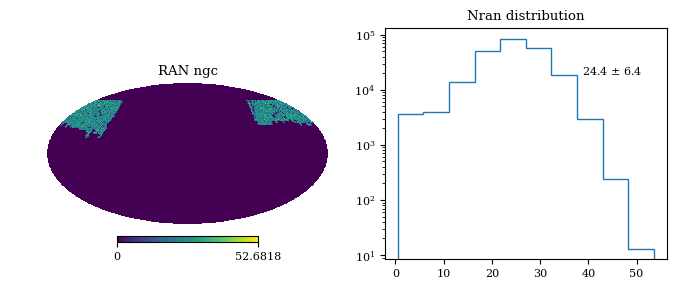

attributes : ('nran', 'sky_g', 'sky_r', 'sky_i', 'sky_z', 'airmass', 'ebv', 'depth_g', 'depth_r', 'depth_i', 'depth_z', 'psf_g', 'psf_r', 'psf_i', 'psf_z', 'w1_med', 'w1_covmed', 'w1_moon', 'star_density')
total mask ran > 0 : 237261
total mask after nan maps : 237220
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3145728 entries, 0 to 3145727
Data columns (total 20 columns):
ngal            float64
nran            float64
mask            bool
sky_g           float64
sky_r           float64
sky_i           float64
sky_z           float64
depth_g         float64
depth_r         float64
depth_i         float64
depth_z         float64
psf_g           float64
psf_r           float64
psf_i           float64
psf_z           float64
w1_med          float64
w1_covmed       float64
star_density    float64
ebv             float64
airmass         float64
dtypes: bool(1), float64(19)
memory usage: 459.0 MB
Info :  None
/Volumes/TimeMachine/data/eboss/v6/qso_hpsyst_ngc.hf already exists going to

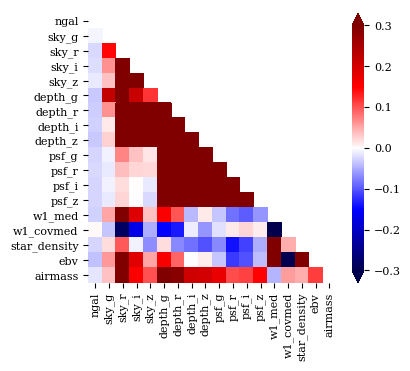

/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/projaxes.py:1053: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/projaxes.py:1054: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


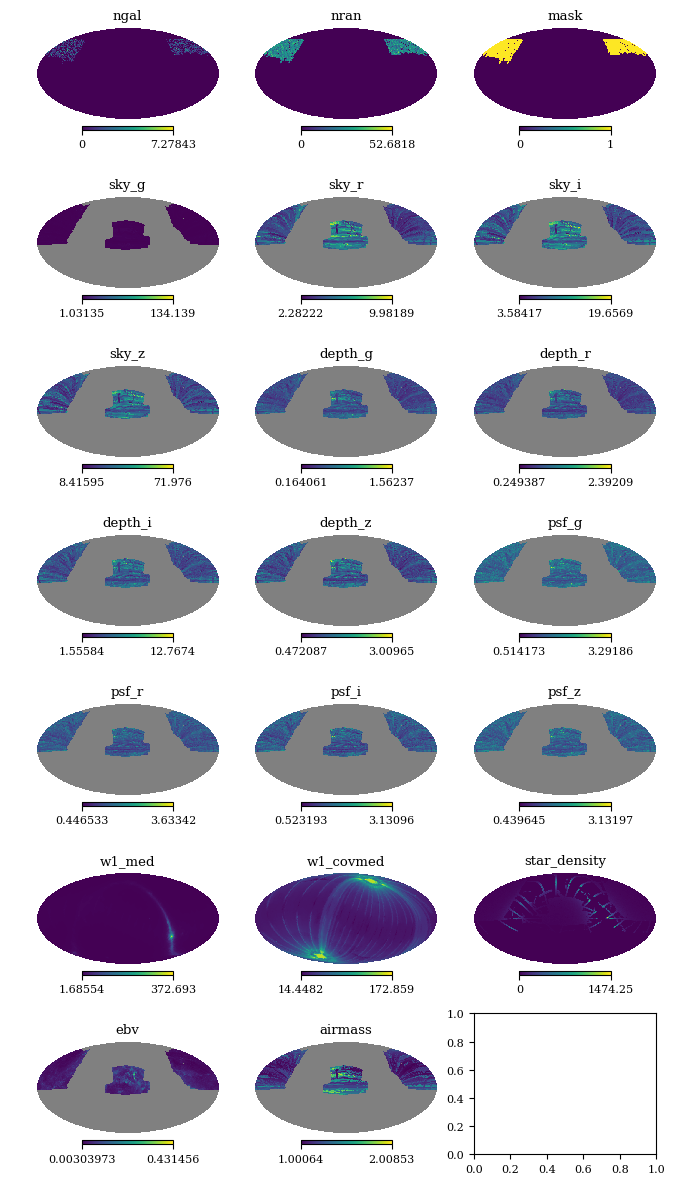

wrote /Volumes/TimeMachine/data/eboss/v6/ngal_features_ngc.fits
wrote /Volumes/TimeMachine/data/eboss/v6/mask.ngc.hp.512.fits
wrote /Volumes/TimeMachine/data/eboss/v6/fracgood.ngc.hp.512.fits


In [4]:
# data
qsocat = CAT([scratch+'eboss/v6/eBOSS_QSO_clustering_NGC_v6.dat.fits'])
qsocat.project2hp()
qsocat.writehp(scratch+'eboss/v6/eBOSS_QSO_clustering_ngc_v6.dat.hp.512.fits')
qsocat.plot_hist(['QSO ngc', 'Nqso distribution'])

# data with systot
qsocat = CAT([scratch+'eboss/v6/eBOSS_QSO_clustering_NGC_v6.dat.fits'], 
            weights=['weight_systot', 'weight_cp', 'weight_noz'])
qsocat.project2hp()
qsocat.writehp(scratch+'eboss/v6/eBOSS_QSO_clustering_ngc_wsys_v6.dat.hp.512.fits')
qsocat.plot_hist(['QSO ngc w_sys', 'Nqso distribution'])

# random
qsocat = CAT([scratch+'eboss/v6/eBOSS_QSO_clustering_NGC_v6.ran.fits'],
             weights=['weight_systot', 'weight_cp', 'weight_noz'])
qsocat.project2hp()
qsocat.writehp(scratch+'eboss/v6/eBOSS_QSO_clustering_ngc_v6.ran.hp.512.fits')
qsocat.plot_hist(['RAN ngc', 'Nran distribution'])


# combine data, random, and imaging attributes
COLS = ['sky_g', 'sky_r', 'sky_i', 'sky_z', 
        'depth_g', 'depth_r', 'depth_i','depth_z',
        'psf_g','psf_r', 'psf_i', 'psf_z',
        'w1_med', 'w1_covmed',
        'star_density', 'ebv', 'airmass']

pdm = combinemaps(scratch+'eboss/v6/eBOSS_QSO_clustering_ngc_v6.dat.hp.512.fits',
                  scratch+'eboss/v6/eBOSS_QSO_clustering_ngc_v6.ran.hp.512.fits',
                  scratch +'/eboss/sysmaps/SDSS_WISE_imageprop_nside512.fits')
pdm.maketable(cols=COLS)
pdm.to_hdf(scratch+'eboss/v6/qso_hpsyst_ngc.hf', 'qso_hpsyst', mode='w', format='fixed')
pdm.plot_corrmax([-.3, .3])
pdm.plot_mollweide()

# read hdf, write label, features to fits
fitname = '/Volumes/TimeMachine/data/eboss/v6/ngal_features_ngc.fits'
metaname = '/Volumes/TimeMachine/data/eboss/v6/qso_hpsyst_ngc.hf'
hpmask   = '/Volumes/TimeMachine/data/eboss/v6/mask.ngc.hp.512.fits'
hpfrac   = '/Volumes/TimeMachine/data/eboss/v6/fracgood.ngc.hp.512.fits'
hd5_2_fits(metaname, fitname, hpmask, hpfrac, COLS)

# randomly split the label features into 5 partitions
ut.read_split_write('/Volumes/TimeMachine/data/eboss/v6/ngal_features_ngc.fits', 
                   '/Volumes/TimeMachine/data/eboss/v6/qso.ngc.hp.512.r',
                   5)

### SGC

len of gal cats 1
num of gal obj 125501
projecting into a healpix map with nside of 512


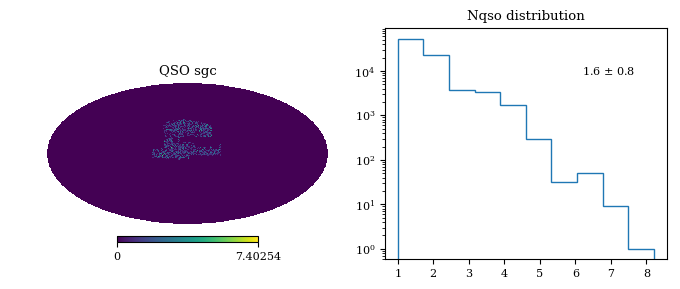

len of gal cats 1
num of gal obj 125501
projecting into a healpix map with nside of 512


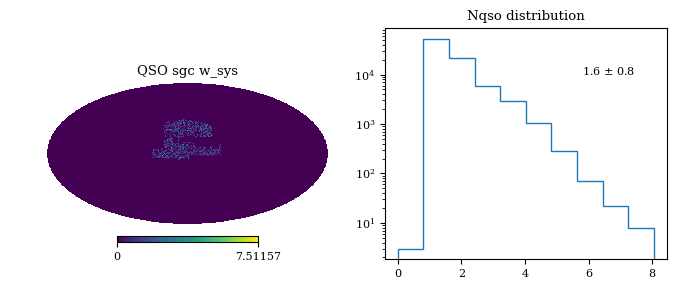

len of gal cats 1
num of gal obj 3587326
projecting into a healpix map with nside of 512


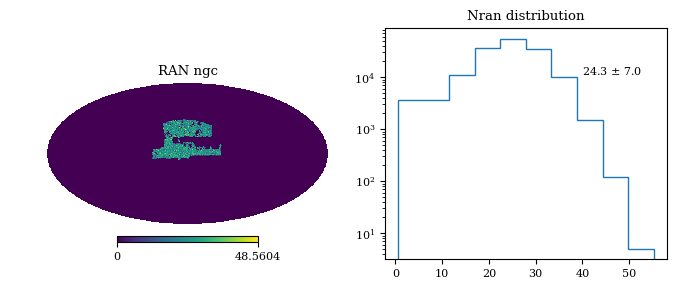

attributes : ('nran', 'sky_g', 'sky_r', 'sky_i', 'sky_z', 'airmass', 'ebv', 'depth_g', 'depth_r', 'depth_i', 'depth_z', 'psf_g', 'psf_r', 'psf_i', 'psf_z', 'w1_med', 'w1_covmed', 'w1_moon', 'star_density')
total mask ran > 0 : 155323
total mask after nan maps : 155282
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3145728 entries, 0 to 3145727
Data columns (total 20 columns):
ngal            float64
nran            float64
mask            bool
sky_g           float64
sky_r           float64
sky_i           float64
sky_z           float64
depth_g         float64
depth_r         float64
depth_i         float64
depth_z         float64
psf_g           float64
psf_r           float64
psf_i           float64
psf_z           float64
w1_med          float64
w1_covmed       float64
star_density    float64
ebv             float64
airmass         float64
dtypes: bool(1), float64(19)
memory usage: 459.0 MB
Info :  None



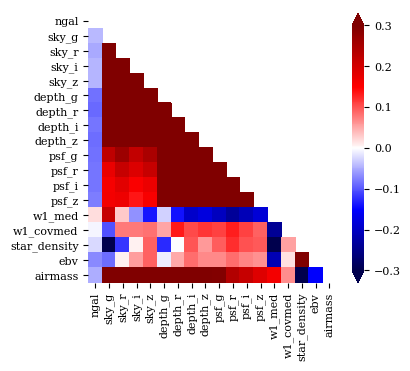

/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/projaxes.py:1053: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/projaxes.py:1054: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


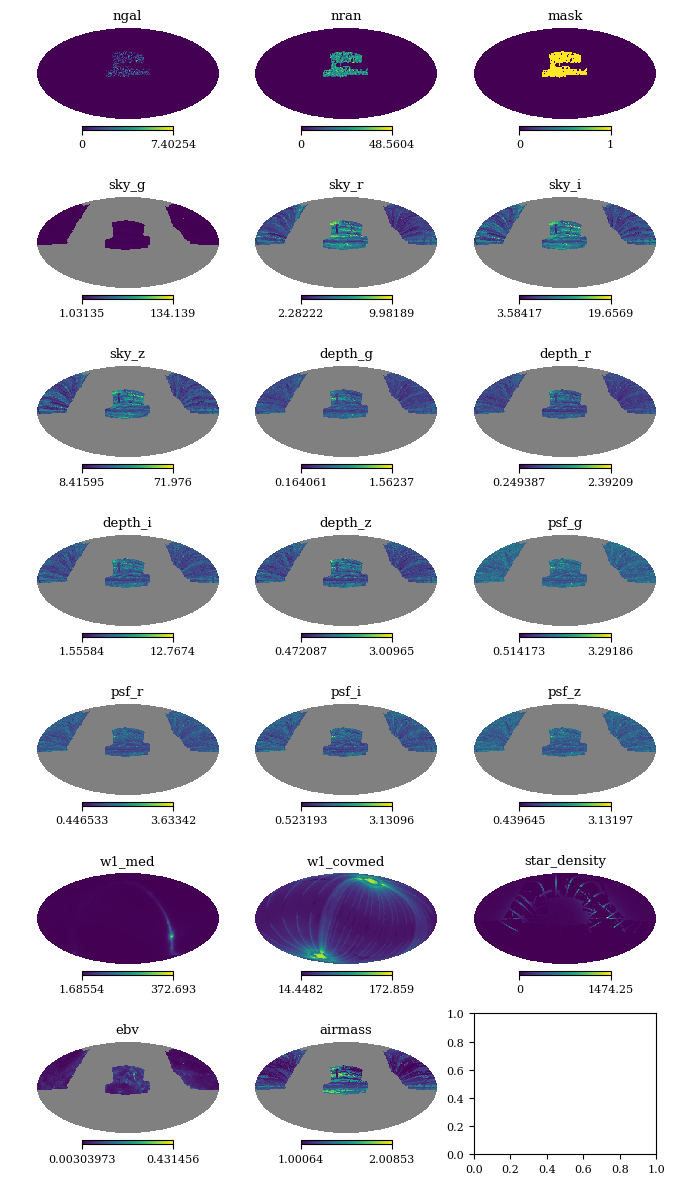

wrote /Volumes/TimeMachine/data/eboss/v6/ngal_features_sgc.fits
wrote /Volumes/TimeMachine/data/eboss/v6/mask.sgc.hp.512.fits
wrote /Volumes/TimeMachine/data/eboss/v6/fracgood.sgc.hp.512.fits


In [5]:
# data
qsocat = CAT([scratch+'eboss/v6/eBOSS_QSO_clustering_SGC_v6.dat.fits'])
qsocat.project2hp()
qsocat.writehp(scratch+'eboss/v6/eBOSS_QSO_clustering_sgc_v6.dat.hp.512.fits')
qsocat.plot_hist(['QSO sgc', 'Nqso distribution'])

# data with systot
qsocat = CAT([scratch+'eboss/v6/eBOSS_QSO_clustering_SGC_v6.dat.fits'], 
            weights=['weight_systot', 'weight_cp', 'weight_noz'])
qsocat.project2hp()
qsocat.writehp(scratch+'eboss/v6/eBOSS_QSO_clustering_sgc_wsys_v6.dat.hp.512.fits')
qsocat.plot_hist(['QSO sgc w_sys', 'Nqso distribution'])

# random
qsocat = CAT([scratch+'eboss/v6/eBOSS_QSO_clustering_SGC_v6.ran.fits'],
             weights=['weight_systot', 'weight_cp', 'weight_noz'])
qsocat.project2hp()
qsocat.writehp(scratch+'eboss/v6/eBOSS_QSO_clustering_sgc_v6.ran.hp.512.fits')
qsocat.plot_hist(['RAN ngc', 'Nran distribution'])

# combine data, random, and imaging attributes
COLS = ['sky_g', 'sky_r', 'sky_i', 'sky_z', 
        'depth_g', 'depth_r', 'depth_i','depth_z',
        'psf_g','psf_r', 'psf_i', 'psf_z',
        'w1_med', 'w1_covmed',
        'star_density', 'ebv', 'airmass']

pdm = combinemaps(scratch+'eboss/v6/eBOSS_QSO_clustering_sgc_v6.dat.hp.512.fits',
                  scratch+'eboss/v6/eBOSS_QSO_clustering_sgc_v6.ran.hp.512.fits',
                  scratch +'/eboss/sysmaps/SDSS_WISE_imageprop_nside512.fits')
pdm.maketable(cols=COLS)
pdm.to_hdf(scratch+'eboss/v6/qso_hpsyst_sgc.hf', 'qso_hpsyst', mode='w', format='fixed')
pdm.plot_corrmax([-.3, .3])
pdm.plot_mollweide()

# read hdf, write label, features to fits
fitname = '/Volumes/TimeMachine/data/eboss/v6/ngal_features_sgc.fits'
metaname = '/Volumes/TimeMachine/data/eboss/v6/qso_hpsyst_sgc.hf'
hpmask   = '/Volumes/TimeMachine/data/eboss/v6/mask.sgc.hp.512.fits'
hpfrac   = '/Volumes/TimeMachine/data/eboss/v6/fracgood.sgc.hp.512.fits'
hd5_2_fits(metaname, fitname, hpmask, hpfrac, COLS)

# randomly split the label features into 5 partitions
ut.read_split_write('/Volumes/TimeMachine/data/eboss/v6/ngal_features_sgc.fits', 
                   '/Volumes/TimeMachine/data/eboss/v6/qso.sgc.hp.512.r',
                   5)

## Ablation

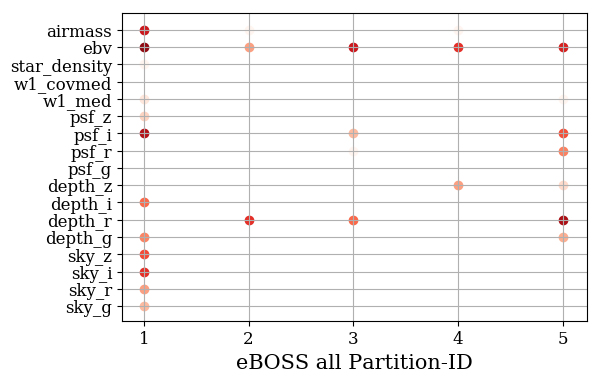

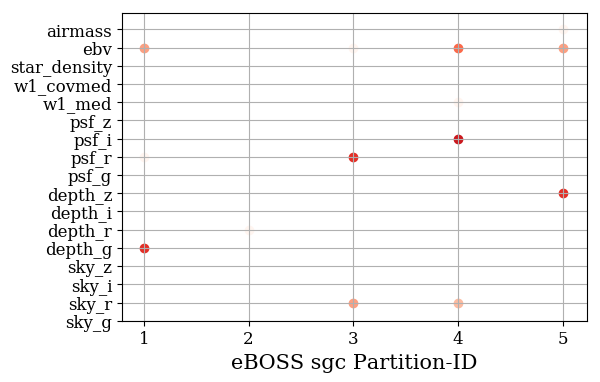

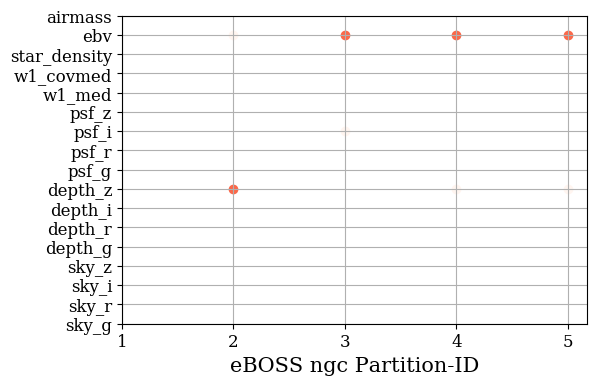

In [2]:
for cap in ['all', 'sgc', 'ngc']:
    hyper_params_data(glob('/Volumes/TimeMachine/data/eboss/v6/results_'+cap+'/ablation/v6.log_fold*.npy'), ['eBOSS '+cap])

In [4]:
nns  = glob('/Volumes/TimeMachine/data/eboss/v6/results_/regression/*/nn-weights.hp512.fits')
masks = glob('/Volumes/TimeMachine/data/eboss/v6/mask.*.hp.512.fits')
nns, masks

(['/Volumes/TimeMachine/data/eboss/v6/results_all/regression/nn_ab/nn-weights.hp512.fits',
  '/Volumes/TimeMachine/data/eboss/v6/results_all/regression/nn_p/nn-weights.hp512.fits',
  '/Volumes/TimeMachine/data/eboss/v6/results_ngc/regression/nn_ab/nn-weights.hp512.fits',
  '/Volumes/TimeMachine/data/eboss/v6/results_ngc/regression/nn_p/nn-weights.hp512.fits',
  '/Volumes/TimeMachine/data/eboss/v6/results_sgc/regression/nn_ab/nn-weights.hp512.fits',
  '/Volumes/TimeMachine/data/eboss/v6/results_sgc/regression/nn_p/nn-weights.hp512.fits'],
 ['/Volumes/TimeMachine/data/eboss/v6/mask.all.cut.hp.512.fits',
  '/Volumes/TimeMachine/data/eboss/v6/mask.all.hp.512.fits',
  '/Volumes/TimeMachine/data/eboss/v6/mask.ngc.cut.hp.512.fits',
  '/Volumes/TimeMachine/data/eboss/v6/mask.ngc.hp.512.fits',
  '/Volumes/TimeMachine/data/eboss/v6/mask.sgc.cut.hp.512.fits',
  '/Volumes/TimeMachine/data/eboss/v6/mask.sgc.hp.512.fits'])

/Volumes/TimeMachine/data/eboss/v6/results/regression/mult_all/lin-weights.hp512.fits
0.44903991209073535 1.3676287426929763
/Volumes/TimeMachine/data/eboss/v6/results/regression/mult_all/quad-weights.hp512.fits
0.37080637803528593 1.5176027062319724
/Volumes/TimeMachine/data/eboss/v6/results/regression/nn_ab/nn-weights.hp512.fits
0.31029618263812286 1.2271591165416917
/Volumes/TimeMachine/data/eboss/v6/results/regression/nn_p/nn-weights.hp512.fits
-0.1362557086903159 3.003935694171566


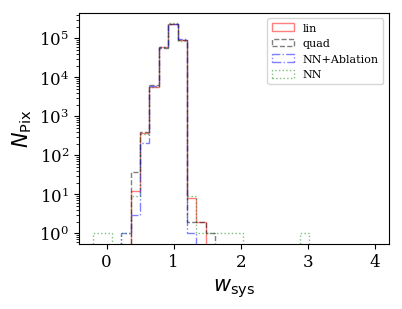

In [4]:
mpl.rcParams.update(mpl.rcParamsDefault)
params = {
'axes.spines.right':True,
'axes.spines.top':True,
'axes.labelsize': 15,
#'text.fontsize': 8,
'legend.fontsize': 8,
'xtick.labelsize': 12,
'ytick.labelsize': 12,
'text.usetex': False,
'figure.figsize': [4, 3],
'font.family':'serif',
'font.size':12
}    
plt.rcParams.update(params) 
ls = ['-', '--', '-.', ':']
lt = ['lin', 'quad', 'NN+Ablation', 'NN']
cl = ['r', 'k', 'b', 'g']
for i,nni in enumerate(nns):
    print(nni)
    nnd = hp.read_map(nni, verbose=False)[mask]
    print(nnd.min(), nnd.max())
    plt.hist(nnd, range=(-0.2, 4), 
             alpha=0.5, bins=30, histtype='step',
             linestyle=ls[i], label=lt[i], color=cl[i])
plt.yscale('log')
plt.ylabel(r'$N_{\rm Pix}$')
plt.xlabel(r'$w_{\rm sys}$')
plt.legend()
_=plt.show()

In [6]:
kw = {'verbose':False}
ngal = hp.read_map('/Volumes/TimeMachine/data/eboss/v6/eBOSS_QSO_clustering_all_v6.dat.hp.512.fits', **kw)
mask = hp.read_map('/Volumes/TimeMachine/data/eboss/v6/mask.hp.512.fits', **kw).astype('bool')
frac = hp.read_map('/Volumes/TimeMachine/data/eboss/v6/fracgood.hp.512.fits', **kw)
nnw  = hp.read_map('/Volumes/TimeMachine/data/eboss/v6/results/regression/nn_ab/nn-weights.hp512.fits', **kw)

In [7]:
nnbar  = ut.makedelta(ngal, weight1=frac, mask=mask) + 1.0
nnw    = nnw / np.mean(nnw[mask])

# nnw[~mask] = np.mean(nnw[mask])
# nnw = hp.smoothing(nnw.copy(), sigma=np.deg2rad(0.1))
nnbarc = ut.makedelta(ngal, weight1=frac, mask=mask, select_fun=nnw) + 1.0

/Users/rezaie/github/SYSNet/src/utils.py:139: RuntimeWarning: divide by zero encountered in true_divide
  gmap = map1 / select_fun
/Users/rezaie/github/SYSNet/src/utils.py:139: RuntimeWarning: invalid value encountered in true_divide
  gmap = map1 / select_fun


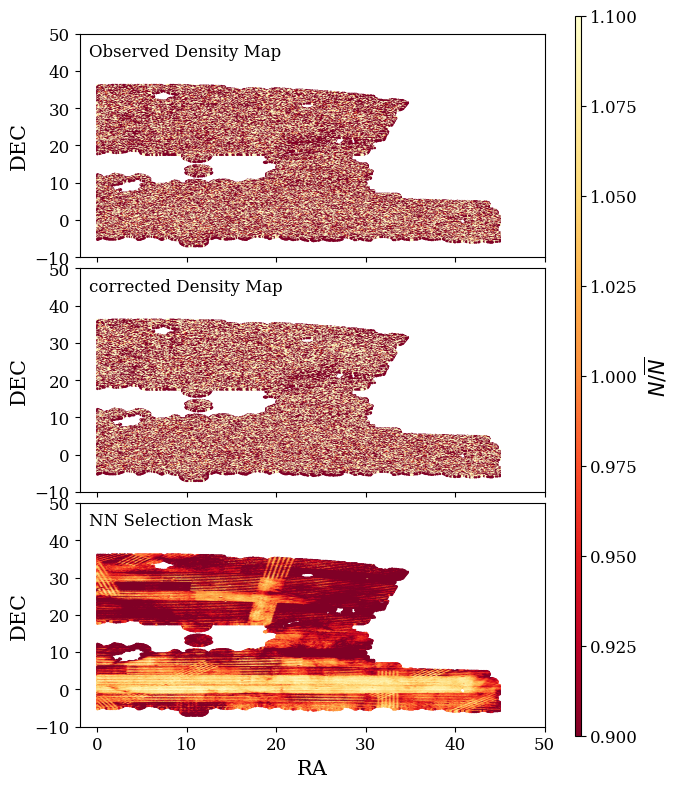

In [8]:
# plt.rc('axes.spines', top=False, right=False)
# plt.rc('font', family='serif')
# plt.rc('text', usetex=True)
hpix = np.argwhere(mask).flatten()
fig, ax = plt.subplots(nrows=3, figsize=(6, 9), sharex=True)
plt.subplots_adjust(hspace=0.05)


#ttl = ['No weights', 'Linear weights', 'NN weights']
ttl = ['Observed Density Map', 'corrected Density Map','NN Selection Mask', ]
#for i,di in enumerate([duni, dlin, dnn]):
for i,di in enumerate([nnbar, nnbarc, nnw]):
    radec = ut.hpix2radec(512, hpix)
    map1 = ax[i].scatter(radec[0], radec[1], 0.5, 
                         #c=5*di[mask], vmin=-1, vmax=1.,
                        c=di[mask], vmin=0.9, vmax=1.1,
                        cmap=plt.cm.YlOrRd_r)
    ax[i].text(0.02, 0.9, ttl[i], transform=ax[i].transAxes)
    ax[-1].set_xlabel('RA')
    ax[i].set_ylabel('DEC')
    ax[i].axis([-2, 50, -10., 50.])
cax = plt.axes([.95, 0.1, 0.01, 0.8])
fig.colorbar(map1, cax=cax, label=r'$N/\overline{N}$')
plt.show()
# plt.savefig('./deltas.png', bbox_inches='tight', dpi=300)

In [23]:
!ls /Volumes/TimeMachine/data/eboss/v6/results_all/clustering

cl_lin.log         cl_sys.png         nnbar_nn_p.npy     xi_nn_ab.npy
cl_lin.npy         cl_uni.log         nnbar_nn_p.png     xi_nn_p.log
cl_lin.png         cl_uni.npy         nnbar_quad.log     xi_nn_p.npy
cl_nn_ab.log       cl_uni.png         nnbar_quad.npy     xi_quad.log
cl_nn_ab.npy       cl_uni_wsys.log    nnbar_quad.png     xi_quad.npy
cl_nn_ab.png       cl_uni_wsys.npy    nnbar_uni.log      xi_sys.log
cl_nn_p.log        cl_uni_wsys.png    nnbar_uni.npy      xi_sys.npy
cl_nn_p.npy        nnbar_lin.log      nnbar_uni.png      xi_uni.log
cl_nn_p.png        nnbar_lin.npy      nnbar_uni_wsys.log xi_uni.npy
cl_quad.log        nnbar_lin.png      nnbar_uni_wsys.npy xi_uni_wsys.log
cl_quad.npy        nnbar_nn_ab.log    nnbar_uni_wsys.png xi_uni_wsys.npy
cl_quad.png        nnbar_nn_ab.npy    xi_lin.log
cl_sys.log         nnbar_nn_ab.png    xi_lin.npy
cl_sys.npy         nnbar_nn_p.log     xi_nn_ab.log


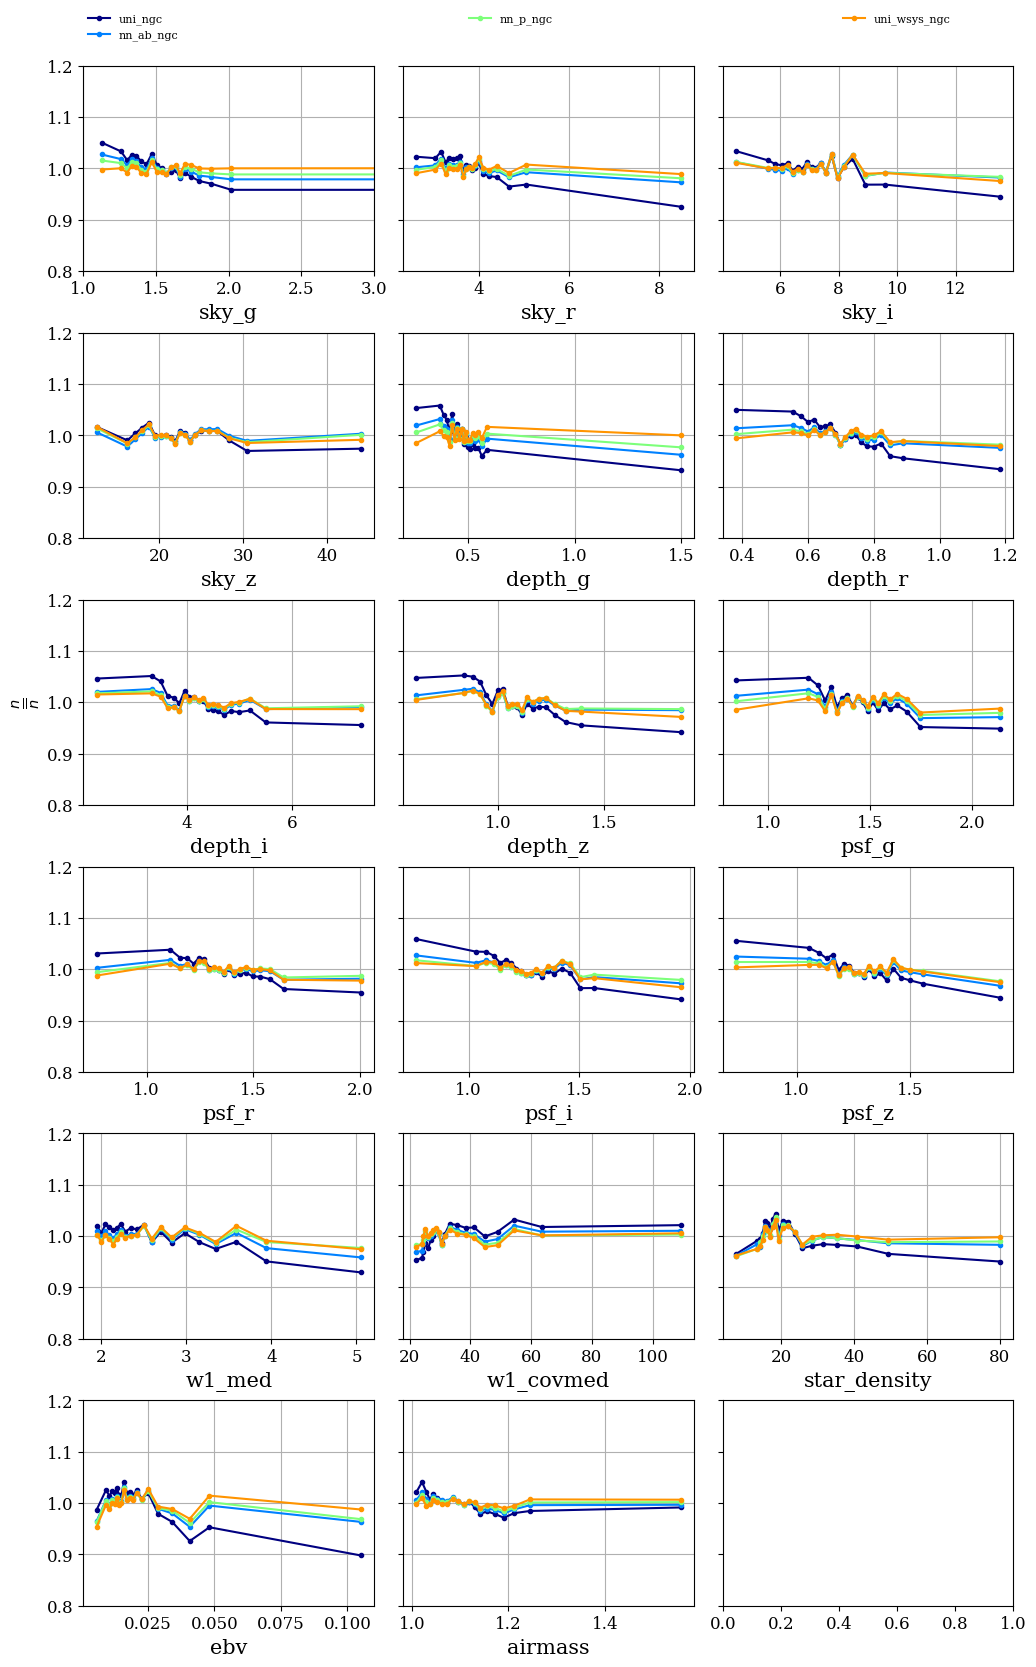

In [37]:
nnbars = glob('/Volumes/TimeMachine/data/eboss/v6/results_ngc/clustering/nnbar_uni.npy')\
       + glob('/Volumes/TimeMachine/data/eboss/v6/results_ngc/clustering/nnbar_nn_*.npy')\
       + glob('/Volumes/TimeMachine/data/eboss/v6/results_ngc/clustering/nnbar_uni_wsys.npy')
print(nnbars)

mpl.rcParams.update(mpl.rcParamsDefault)
params = {
'axes.spines.right':True,
'axes.spines.top':True,
'axes.labelsize': 15,
#'text.fontsize': 8,
'legend.fontsize': 8,
'xtick.labelsize': 12,
'ytick.labelsize': 12,
'text.usetex': False,
'figure.figsize': [4, 3],
'font.family':'serif',
'font.size':12
}    
plt.rcParams.update(params) 

fig, ax = plt.subplots(ncols=3, nrows=6, figsize=(12, 20), sharey=True)
plt.subplots_adjust(hspace=0.3, wspace=0.1)
ax = ax.flatten()

#lt = ['lin', 'NN+Ablation', 'NN', 'quad', 'No Correction']
#cl = ['r', 'b', 'k', 'g', 'purple']
ls = ['--', ':', '-', '-.', '-']
n  = len(nnbars)
cl  = plt.cm.jet
for j,nnbar_i in enumerate(nnbars):
    nnbar = np.load(nnbar_i).item()
    lt = '_'.join((nnbar_i.split('/')[-1].split('.')[0][6:], nnbar_i.split('/')[6].split('_')[-1]))
    for i in range(len(nnbar['nnbar'])):
        mynnb = nnbar['nnbar'][i]
        x = 0.5*(mynnb['bin_edges'][1:]+mynnb['bin_edges'][:-1])
        y = mynnb['nnbar']
        ye = mynnb['nnbar_err']
        ax[i].plot(x, y, marker='.', color=cl(j/n), label=lt)
        if j ==n-1:
            ax[0].legend(**dict(ncol=3,frameon=False,
                 bbox_to_anchor=(0, 1.1, 3, 0.4), loc="lower left",
                mode="expand", borderaxespad=0))
            ax[0].set_xlim(1, 3)
            ax[i].set_ylim(0.8, 1.2)
            ax[i].set_xlabel(nnbar['xlabels'][i])
            ax[i].grid()
            if i==6:ax[i].set_ylabel(r'$\frac{n}{\overline{n}}$')
plt.show()                

In [20]:
kw   = dict(verbose=False)
frac = hp.read_map('/Volumes/TimeMachine/data/eboss/v6/fracgood.hp.512.fits', **kw)
mask = hp.read_map('/Volumes/TimeMachine/data/eboss/v6/mask.cut.hp.512.fits', **kw).astype('bool')
ngal = hp.read_map('/Volumes/TimeMachine/data/eboss/v6/eBOSS_QSO_clustering_all_v6.dat.hp.512.fits', **kw)

area = hp.nside2pixarea(512, degrees=True)*frac[mask].sum()*3.0462e-4
shotnoise = area/ngal[mask].sum()
print('shotnoise,', area/ngal[mask].sum())
print('fsky', frac[mask].sum()/mask.size)

shotnoise, 4.295060549836234e-06
fsky 0.12477026862386136


In [38]:
def plot_clxi(filen, filen2, ax, ttl):    
    mpl.rcParams.update(mpl.rcParamsDefault)
    params = {
    'axes.spines.right':True,
    'axes.spines.top':True,
    'axes.labelsize': 15,
    #'text.fontsize': 8,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex': False,
    'figure.figsize': [4, 3],
    'font.family':'serif',
    'font.size':12
    }    
    plt.rcParams.update(params) 

    lb = ['uni', 'uni_wsys', 'nn_ab']
    lt = ['no correction', 'systot', 'nn']
    c  = ['k', 'royalblue', 'crimson', 'g', '', 'purple']
    ls = ['-', '--', '-', '-.', '', '-']

#     fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
#     plt.subplots_adjust(wspace=0.4)

    kw = dict(bins=np.logspace(np.log10(0.9), np.log10(1030), 10))
    for i,lbi in enumerate(lb):
        cl = np.load(filen(lbi)).item()
        elb, clbe = ut.binit_jac(cl['clerr']['cljks'], **kw)
        elb, clb  = ut.binit(np.arange(cl['auto'].size), cl['auto']-4.295060549836234e-6, **kw)
        #print(clb)
        ax[0].errorbar(elb, clb, yerr=clbe, marker='.', linestyle=ls[i], color=c[i], label=lt[i])
    ax[0].legend(title=ttl)
    ax[0].loglog()
    ax[0].set_ylim(1.e-7, 1.e-2)
    ax[0].set_xlabel(r'$\ell$')
    ax[0].set_ylabel(r'$C_{\ell}$')

    fc = 1.e2
    for i, xii in enumerate(lb):
        d = np.load(filen2(xii)).item()['auto']
        t  = 0.5*np.degrees(d['t'][1:]+d['t'][:-1])
        xi = fc*(d['w']-d['dmean']*d['dmean'])

        xierr=d['werr']
        ax[1].errorbar(t, xi, yerr=fc*xierr, linestyle=ls[i], color=c[i], label=lt[i])
        #ax[0].legend(bbox_to_anchor=(0, 1.1, 2, 0.4), loc="lower left",
        #            mode="expand", borderaxespad=0, ncol=3, frameon=False)    
        ax[1].set_xlabel(r'$\theta [deg]$')
        ax[1].set_ylabel(r'$10^{2}\times \omega(\theta)$')
        ax[1].set_xlim(-0.2, 10)
        ax[1].set_ylim(-0.5, 2.0)
        ax[1].grid()
    #plt.show()
    
    


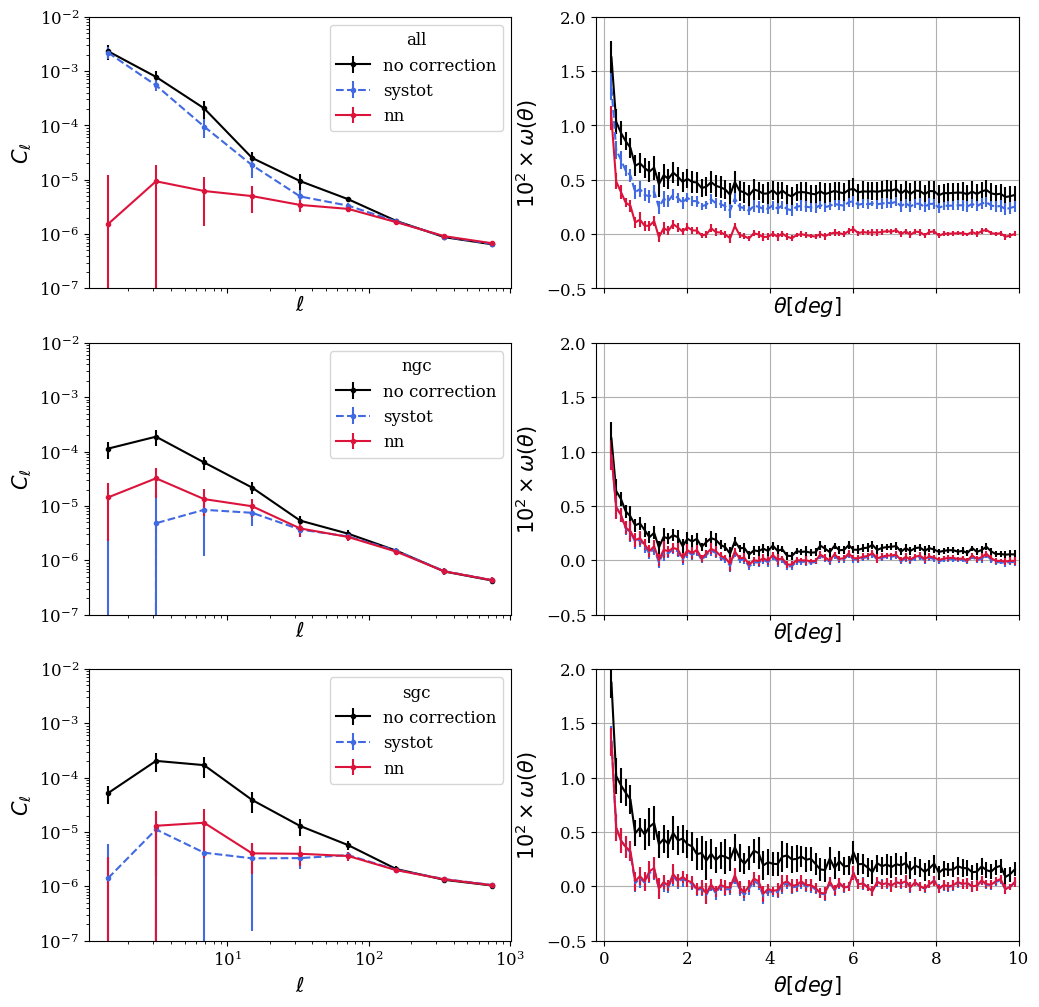

In [39]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(12, 12), sharex='col')
ax = ax.flatten()
# plt.subplots_adjust(hspace=0.0)

for i,cap in enumerate(['all', 'ngc', 'sgc']):
    filen = lambda l:'/Volumes/TimeMachine/data/eboss/v6/results_'+cap+'/clustering/cl_'+l+'.npy'
    filen2 = lambda l:'/Volumes/TimeMachine/data/eboss/v6/results_'+cap+'/clustering/xi_'+l+'.npy'
    plot_clxi(filen, filen2, [ax[2*i], ax[2*i+1]], cap)
plt.show()    